# Inverting Gradients - How easy is it to break privacy in federated learning?

This notebook shows an example for a **large(r)-batch image gradient inversion** as described in "Inverting Gradients - How easy is it to break privacy in federated learning?". The setting is an untrained ResNet32-10 and the federated learning algorithm is **fedSGD**.

Paper URL: https://proceedings.neurips.cc/paper/2020/hash/c4ede56bbd98819ae6112b20ac6bf145-Abstract.html

This is basically the experiment of Fig.6 in this paper.

#### Abstract
The idea of federated learning is to collaboratively train a neural network on a server. Each user receives the current weights of the network and in turns sends parameter updates (gradients) based on local data. This protocol has been designed not only to train neural networks data-efficiently, but also to provide privacy benefits for users, as their input data remains on device and only parameter gradients are shared. But how secure is sharing parameter gradients? Previous attacks have provided a false sense of security, by succeeding only in contrived settings - even for a single image. However, by exploiting a magnitude-invariant loss along with optimization strategies based on adversarial attacks, we show that is is actually possible to faithfully reconstruct images at high resolution from the knowledge of their parameter gradients, and demonstrate that such a break of privacy is possible even for trained deep networks. We analyze the effects of architecture as well as parameters on the difficulty of reconstructing an input image and prove that any input to a fully connected layer can be reconstructed analytically independent of the remaining architecture. Finally we discuss settings encountered in practice and show that even averaging gradients over several iterations or several images does not protect the user's privacy in federated learning applications.

### Startup

In [32]:
try:
    import breaching
except ModuleNotFoundError:
    # You only really need this safety net if you want to run these notebooks directly in the examples directory
    # Don't worry about this if you installed the package or moved the notebook to the main directory.
    import os; os.chdir("..")
    import breaching

import torch
import torch.nn as nn
import torchvision.models as models

%load_ext autoreload
%autoreload 2

# Redirects logs directly into the jupyter notebook
import logging, sys
logging.basicConfig(level=logging.INFO, handlers=[logging.StreamHandler(sys.stdout)], format='%(message)s')
logger = logging.getLogger()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Initialize cfg object and system setup:

This will load the full configuration object. This includes the configuration for the use case and threat model as `cfg.case` and the hyperparameters and implementation of the attack as `cfg.attack`. All parameters can be modified below, or overriden with `overrides=` as if they were cmd-line arguments.

In [26]:
cfg = breaching.get_config(overrides=[
    "case=6_large_batch_cifar", 
    "case.model=ResNet18-10",
    "case.data.name=CIFAR10",
    "case.data.classes=10"
])          

device = torch.device(f'cuda:0') if torch.cuda.is_available() else torch.device('cpu')
torch.backends.cudnn.benchmark = cfg.case.impl.benchmark
setup = dict(device=device, dtype=getattr(torch, cfg.case.impl.dtype))
setup

Investigating use case large_batch_cifar with server type honest_but_curious.


C:\Users\mmRoshani\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\breaching\__init__.py:18: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  with hydra.initialize(config_path="config"):


{'device': device(type='cuda', index=0), 'dtype': torch.float32}

### Modify config options here

You can use `.attribute` access to modify any of these configurations for the attack, or the case:

In [41]:
cfg.case.data.partition="balanced"
cfg.case.user.user_idx = 0

cfg.case.user.provide_labels = False
cfg.case.user.num_data_points = 10
cfg.attack.label_strategy = "yin" # also works here, as labels are unique

cfg.case.data.mean = [0.4914, 0.4822, 0.4465]
cfg.case.data.std = [0.2470, 0.2435, 0.2616]

cfg.case.server.model_state = "custom"
cfg.case.server.pretrained = False

cfg.case.data.default_clients = 10

# Total variation regularization needs to be smaller on CIFAR-10:
cfg.attack.regularization.total_variation.scale = 5e-4

### Custom ResNet-18 & Loss function

In [58]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.name = 'ResNet18'

        self.resnet = models.resnet18(pretrained=False)
        self.resnet.fc = nn.Sequential(nn.Linear(512, 10))

    def forward(self, x=None, **kwargs):
        """
        Forward pass that handles both positional and keyword arguments.
        
        Args:
            x: Direct input tensor (used when called as model(x))
            **kwargs: Keyword arguments (used when called as model(**data))
        """
        # Case 1: Direct positional argument (model(x))
        if x is not None:
            input_tensor = x
        
        # Case 2: Input provided as keyword argument
        else:
            # Check for common input keys
            if 'inputs' in kwargs:
                input_tensor = kwargs['inputs']
            elif 'images' in kwargs:
                input_tensor = kwargs['images']
            elif 'x' in kwargs:
                input_tensor = kwargs['x']
            else:
                # If none of the expected keys are found, look for the first tensor
                for key, value in kwargs.items():
                    if isinstance(value, torch.Tensor):
                        if len(value.shape) == 4:  # Assuming image input has 4 dimensions
                            input_tensor = value
                            break
                else:
                    # If no suitable tensor is found, raise an error
                    raise ValueError(f"No suitable input tensor found. Keys: {list(kwargs.keys())}")
        
        # Process through the model
        out = self.resnet(input_tensor)
        return out

In [59]:
model = Net()

custom_resnet_18_state = "resnet18-n20/global_cluster0_aggregated.pth"
model.load_state_dict(torch.load(custom_resnet_18_state, map_location=device))

C:\Users\mmRoshani\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\mmRoshani\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\mmRoshani\AppData\Local\Temp\ipykernel_5736\1818088847.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute 

<All keys matched successfully>

In [60]:
loss_fn = torch.nn.CrossEntropyLoss()

### Instantiate all parties

The following lines generate "server, "user" and "attacker" objects and print an overview of their configurations.

#### Making Server

In [61]:
server = breaching.cases.construct_server(model, loss_fn, cfg.case, setup)

#### Making User

In [62]:
user = breaching.cases.construct_user(model, loss_fn, cfg.case, setup)

Files already downloaded and verified


#### Initializing Attacker

In [71]:
print(cfg.attack)

{'type': 'invertinggradients', 'attack_type': 'optimization', 'label_strategy': 'yin', 'text_strategy': 'run-embedding', 'token_recovery': 'from-labels', 'objective': {'type': 'cosine-similarity', 'scale': 1.0, 'task_regularization': 0.0}, 'restarts': {'num_trials': 1, 'scoring': 'cosine-similarity'}, 'init': 'randn', 'normalize_gradients': False, 'optim': {'optimizer': 'adam', 'signed': 'hard', 'step_size': 0.1, 'boxed': True, 'max_iterations': 24000, 'step_size_decay': 'step-lr', 'langevin_noise': 0.0, 'warmup': 0, 'grad_clip': None, 'callback': 1000}, 'augmentations': None, 'differentiable_augmentations': False, 'regularization': {'total_variation': {'scale': 0.0005, 'inner_exp': 1, 'outer_exp': 1}}, 'impl': {'dtype': 'float', 'mixed_precision': False, 'JIT': None}}


In [63]:
# user, server, model, loss_fn = breaching.cases.construct_case(cfg.case, setup)
attacker = breaching.attacks.prepare_attack(server.model, server.loss, cfg.attack, setup)
breaching.utils.overview(server, user, attacker)

Model architecture ResNet18 loaded with 11,181,642 parameters and 9,620 buffers.
Overall this is a data ratio of     364:1 for target shape [10, 3, 32, 32] given that num_queries=1.
User (of type UserSingleStep) with settings:
    Number of data points: 10

    Threat model:
    User provides labels: False
    User provides buffers: False
    User provides number of data points: True

    Data:
    Dataset: CIFAR10
    user: 0
    
        
Server (of type HonestServer) with settings:
    Threat model: Honest-but-curious
    Number of planned queries: 1
    Has external/public data: False

    Model:
        model specification: ResNet18
        model state: custom
        public buffers: True

    Secrets: {}
    
Attacker (of type OptimizationBasedAttacker) with settings:
    Hyperparameter Template: invertinggradients

    Objective: Cosine Similarity with scale=1.0 and task reg=0.0
    Regularizers: Total Variation, scale=0.0005. p=1 q=1. 
    Augmentations: 

    Optimization Setu

### Simulate an attacked FL protocol

This exchange is a simulation of a single query in a federated learning protocol. The server sends out a `server_payload` and the user computes an update based on their private local data. This user update is `shared_data` and contains, for example, the parameter gradient of the model in the simplest case. `true_user_data` is also returned by `.compute_local_updates`, but of course not forwarded to the server or attacker and only used for (our) analysis.

In [64]:
server_payload = server.distribute_payload()
shared_data, true_user_data = user.compute_local_updates(server_payload)

Computing user update on user 0 in model mode: eval.


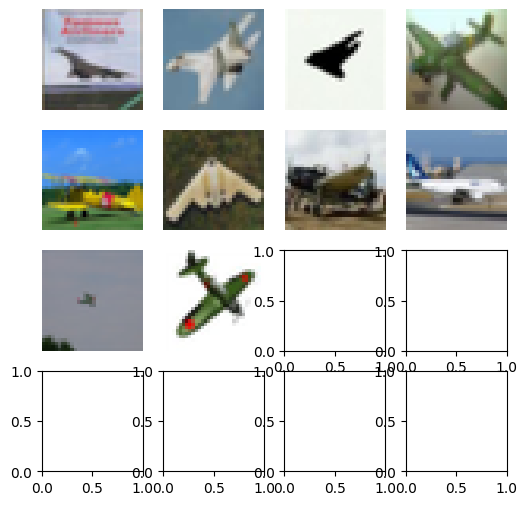

In [66]:
user.plot(true_user_data)

### Reconstruct user data:

Now we launch the attack, reconstructing user data based on only the `server_payload` and the `shared_data`. 

You can interrupt the computation early to see a partial solution.

In [67]:
reconstructed_user_data, stats = attacker.reconstruct([server_payload], [shared_data], {}, dryrun=cfg.dryrun)

Recovered labels [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] through strategy yin.
| It: 1 | Rec. loss: 0.7352 |  Task loss: 17.4934 | T: 0.93s
| It: 1001 | Rec. loss: 0.2288 |  Task loss: 36.5807 | T: 39.21s
| It: 2001 | Rec. loss: 0.2403 |  Task loss: 35.5808 | T: 40.93s
| It: 3001 | Rec. loss: 0.2496 |  Task loss: 35.8634 | T: 42.54s
| It: 4001 | Rec. loss: 0.2469 |  Task loss: 38.6776 | T: 44.57s
| It: 5001 | Rec. loss: 0.2362 |  Task loss: 35.6329 | T: 42.85s
| It: 6001 | Rec. loss: 0.2419 |  Task loss: 38.0804 | T: 41.28s
| It: 7001 | Rec. loss: 0.2522 |  Task loss: 36.7430 | T: 39.84s
| It: 8001 | Rec. loss: 0.2531 |  Task loss: 39.0012 | T: 39.65s
| It: 9001 | Rec. loss: 0.2479 |  Task loss: 36.7087 | T: 39.57s
| It: 10001 | Rec. loss: 0.2180 |  Task loss: 35.2414 | T: 41.34s
| It: 11001 | Rec. loss: 0.2192 |  Task loss: 33.7915 | T: 39.76s
| It: 12001 | Rec. loss: 0.2184 |  Task loss: 33.3473 | T: 37.57s
| It: 13001 | Rec. loss: 0.2246 |  Task loss: 32.4250 | T: 40.78s
| It: 14001 | Rec. l

Next we'll evaluate metrics, comparing the `reconstructed_user_data` to the `true_user_data`.

In [69]:
metrics = breaching.analysis.report(reconstructed_user_data, true_user_data, [server_payload], 
                                    server.model, order_batch=True, compute_full_iip=False, 
                                    cfg_case=cfg.case, setup=setup)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to C:\Users\mmRoshani/.cache\torch\hub\checkpoints\alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:36<00:00, 6.72MB/s] 
C:\Users\mmRoshani\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lpips\lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.s

Files already downloaded and verified
METRICS: | MSE: 0.1182 | PSNR: 10.03 | FMSE: 4.2099e+01 | LPIPS: 0.22|
 R-PSNR:  nan | IIP-pixel: 0.00% | SSIM: nan | max R-PSNR:  nan | max SSIM: nan | Label Acc: 10.00%


And finally, we also plot the reconstructed data:

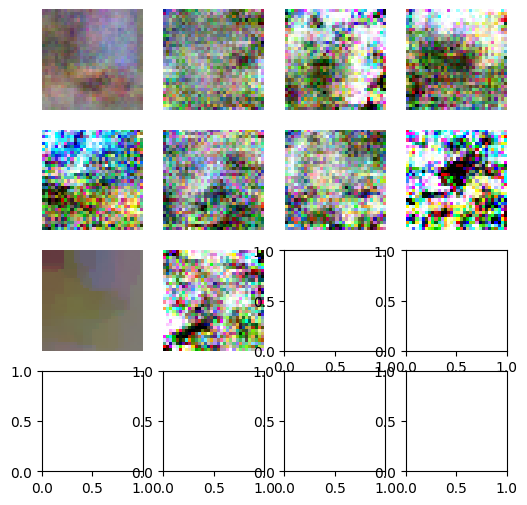

In [70]:
user.plot(reconstructed_user_data)

### Notes:
* Label recovery works reasonably well in this example. Especially as labels are unique in the default settings.
* The interesting part here is not that most images are unrecognizable (they are), but that a few select images do get reconstructed very well.
* Also note that this model is quite large for an experiment on CIFAR-100